La idea de este notebook es simplemente calcular las correcciones necesarias a la cantidad de carga de los clústers, tanto por exceso de carga (eventos espurios en la superficie de los clústers) como por defecto de carga (eventos reales de los bordes de los clusters, eliminados por la aplicación de un corte de calidad que elimina eventos de 1 electrón). En este notebook en ningún momento se buscan los clusters ni se extrae ningún tipo de información de ellos.

In [1]:
import os
import numpy as np
from scipy import ndimage as ndi
from scipy.stats import poisson
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

from analyfits import misc
from analyfits.manipufits import ManipulateFits
from analyfits import datafits

In [2]:
# Cargo una lista con los directorios de todas las imágenes.
DIR = "/home/igna/Escritorio/Tesis2021/Archivos/T123K_B"
#DIR_win = "D:\ignag\Igna\Facultad\Tesis2021\Archivos\T123K_B"
os.chdir(DIR)
fits_imgs_list = misc.fits_finder(DIR)

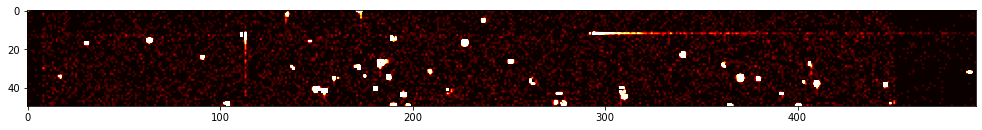

In [3]:
img = ManipulateFits()
os.chdir("/home/igna/Escritorio/Tesis2021/Archivos/T123K_B/210204/210924_F_T123K_NSAMP300_NROW50_expo0_col75")
lista = os.listdir()
img = lista[23]

image = ManipulateFits()
image.ADU2e(img)
image.easy_plot()

In [4]:
diccionarios = datafits.cluster_info_extract(img, low_th=1, upp_th=600000)
df = pd.DataFrame.from_dict(diccionarios[0])

In [5]:
df[(df["areas"]==9)]# & (df["energias"]==2)]

,areas,centros,coordenadas,perimetro,energias
98,9,"(3.3333333333333335, 392.1111111111111)","[[1, 392], [2, 392], [2, 394], [3, 393], [4, 3...",5.414214,10.0
175,9,"(6.111111111111111, 184.11111111111111)","[[4, 184], [5, 183], [5, 185], [6, 182], [6, 1...",8.071068,14.0
307,9,"(11.222222222222221, 92.0)","[[9, 93], [10, 90], [10, 93], [11, 91], [11, 9...",5.828427,9.0
429,9,"(15.555555555555555, 17.0)","[[14, 16], [14, 18], [15, 15], [15, 17], [16, ...",8.242641,11.0
494,9,"(18.88888888888889, 94.11111111111111)","[[17, 94], [17, 96], [18, 95], [18, 96], [19, ...",7.035534,10.0
676,9,"(24.88888888888889, 52.22222222222222)","[[24, 50], [24, 51], [24, 52], [25, 51], [25, ...",7.621320,9.0
822,9,"(31.555555555555557, 344.0)","[[29, 342], [30, 342], [31, 343], [31, 344], [...",8.449747,10.0
827,9,"(29.77777777777778, 425.77777777777777)","[[29, 425], [29, 426], [29, 427], [29, 428], [...",8.242641,12.0
952,9,"(35.666666666666664, 229.0)","[[34, 229], [34, 230], [34, 231], [35, 229], [...",8.828427,13.0
1073,9,"(40.666666666666664, 175.0)","[[39, 177], [40, 172], [40, 176], [40, 177], [...",8.828427,9.0


In [6]:
image = ManipulateFits()
image_e = image.ADU2e(img)
image_e_bw = misc.img2bw(image_e, low_th=1, upp_th=200)
image_e_bw

array([[ True,  True,  True, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       ...,
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False]])

# 1) $\mu_{T}$
## Calculo la contribución total en el primer borde cercano a clusters

In [7]:
ones = 0
zeros = 0
for i, img in enumerate(fits_imgs_list):
    # Original
    fits_image = ManipulateFits()
    img_original = fits_image.ADU2e(img)[:, 8:451]
    # 2 o más eventos
    img_clusters = fits_image.single_fits2double_fits(img)[1][:, 8:451]
    # Estructura
    struct = [[1,1,1],
              [1,1,1],
              [1,1,1]]
    
    # Máscara (dilato 1 vez)
    mask = ndi.morphology.binary_dilation(img_clusters, structure=struct)
    # Resta: A la máscara le saco los pixeles donde hay eventos de 2 o más
    mask = np.where(img_clusters!=0, 0, mask)
    # A la imagen original le saco todos los eventos menos los que cayeron en la mask
    img_1e = np.where(mask!=0, img_original, 0)
    # acumulo
    ones += img_1e[img_1e!=0].size
    zeros += np.sum(mask)
    porcentaje = (i+1)*100/len(fits_imgs_list)
    print(f"\rCompletado {porcentaje:.2f}%",end= "")
mu_T, error_mu_T = ones/zeros, np.sqrt((1/np.sqrt(ones))**2 + (1/np.sqrt(zeros))**2)*(ones/zeros)

Completado 100.00%

# 2) $\mu_{bkg}$
## Calculo la contribución del background a la esperanza total de eventos de 1 electron usando unicamente los eventos en el segundo borde cercano a los clusters

In [8]:
ones = 0
zeros = 0
for i, img in enumerate(fits_imgs_list):
    # Original
    fits_image = ManipulateFits()
    img_original = fits_image.ADU2e(img)[:, 8:451]
    # 2 o más eventos
    img_clusters = fits_image.single_fits2double_fits(img)[1][:, 8:451]
    # Estructura
    struct = [[1,1,1],
              [1,1,1],
              [1,1,1]]
    
    # Máscara1 (dilato 1 vez)
    mask_1 = ndi.morphology.binary_dilation(img_clusters, structure=struct)
    # máscara2 (dilato 1 vez mask_1)
    mask_2 = ndi.morphology.binary_dilation(mask_1, structure=struct)
    # Resta: A la máscara2 le saco los pixeles de mask_1
    mask_2 = np.where(mask_1!=0, 0, mask_2)
    # A la imagen original le saco todos los eventos menos los que cayeron en la mask
    img_1e = np.where(mask_2!=0, img_original, 0)
    # acumulo
    ones += img_1e[img_1e!=0].size
    zeros += np.sum(mask_2)
    porcentaje = (i+1)*100/len(fits_imgs_list)
    print(f"\rCompletado {porcentaje:.2f}%",end= "")
mu_bkg, error_mu_bkg = ones/zeros, np.sqrt((1/np.sqrt(ones))**2 + (1/np.sqrt(zeros))**2)*(ones/zeros)

Completado 100.00%

# 3) $\mu_{g}$
## Calculo la esperanza para los eventos de un electrón genuinos

In [9]:
mu_g = mu_T - mu_bkg
error_mu_g = error_mu_T - error_mu_bkg

In [10]:
print(f"mu_T = {mu_T:.10f} +/- {error_mu_T:.10f}")
print(f"mu_bkg = {mu_bkg:.10f} +/- {error_mu_bkg:.10f}")
print(f"mu_g = {mu_g:.10f} +/- {error_mu_g:.10f}")

mu_T = 0.2040467221 +/- 0.0002426469
mu_bkg = 0.1900231892 +/- 0.0002050072
mu_g = 0.0140235329 +/- 0.0000376398
